# Chest X-Ray Medical Diagnosis with Deep Learning

## Imports

In [1]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

In [2]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

I0000 00:00:1740556698.198444   20984 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740556698.257033   20984 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740556698.261429   20984 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.17.0')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [4]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [5]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.IMAGES_DIR)

datasets/images-small/


In [6]:
IMAGE_DIR = Path(cfg.DATASET_DIRS.IMAGES_DIR)
TRAIN_CSV = Path(cfg.DATASET_DIRS.TRAIN_CSV)
VALID_CSV = Path(cfg.DATASET_DIRS.VALID_CSV)
TEST_CSV = Path(cfg.DATASET_DIRS.TEST_CSV)



BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
IMAGE_SIZE = cfg.TRAIN.IMG_SIZE

## Load the Datasets
[ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.

### Loading the Data

In [7]:
train_df = pd.read_csv(f"{TRAIN_CSV}")
valid_df = pd.read_csv(f"{VALID_CSV}")

test_df = pd.read_csv(f"{TEST_CSV}")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

### Total Labels

In [9]:
column_names = list(train_df.columns)
labels = column_names[1:]
labels.remove('PatientId')
labels, len(labels)

(['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'],
 14)

In [10]:
train_df_labels = train_df[labels]
train_df_labels.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [11]:
valid_df_labels = valid_df[labels]
test_df_labels = test_df[labels]

## Data Leakage Prevent

check if there are patients in both train and test or in both valid and test.

In [12]:
def check_for_dataleakage(df1, df2, patentId_col='PatientId'):
    """
    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    df1_patients_unique = df1[patentId_col].unique()
    df2_patients_unique = df2[patentId_col].unique()

    patients_in_common = np.intersect1d(df1_patients_unique, df2_patients_unique)

    leakage = True if (len(patients_in_common) > 0) else False
    return leakage

In [13]:
check_for_dataleakage(train_df, valid_df)

True

In [14]:
check_for_dataleakage(train_df, test_df)

False

In [15]:
check_for_dataleakage(test_df, valid_df)

False

### Load Training Dataset from Dataframe

Check for images

In [16]:
def is_image_exists(df):
    temp_df = df.copy() 
    for idx, image_path in enumerate(df.Image.values):
        tf.io.read_file(f"{IMAGE_DIR/image_path}")
        if not Path(f"{IMAGE_DIR/image_path}").exists():
            print(f"Image {image_path} does not exist")
            temp_df = temp_df.drop(idx)

    return temp_df

In [17]:
is_image_exists(train_df)

I0000 00:00:1740556699.572223   20984 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740556699.574219   20984 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740556699.576336   20984 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740556699.690952   20984 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,00015869_010.png,0,0,0,0,0,0,0,0,0,0,0,15869,0,0,0
996,00020113_005.png,0,0,0,0,1,0,0,0,0,0,0,20113,0,0,0
997,00019939_000.png,0,0,0,0,0,0,0,0,0,0,0,19939,0,0,0
998,00030496_000.png,0,0,0,0,0,0,0,0,0,0,0,30496,0,0,0


In [34]:
def load_image(image_name, label):
    full_path = tf.strings.join([f'{IMAGE_DIR}/', image_name])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Resize to the desired size
    return image, label


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_df.Image.values,  train_df_labels.values))
train_ds = train_ds.map(load_image, num_parallel_calls=-1)

In [36]:
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df.Image.values,  valid_df_labels.values))
valid_ds = valid_ds.map(load_image, num_parallel_calls=-1)

In [37]:
for batch in train_ds.take(1):
    image, label = batch
    print(image, label)

tf.Tensor(
[[[203.48     203.48     203.48    ]
  [194.97     194.97     194.97    ]
  [184.2      184.2      184.2     ]
  ...
  [192.       192.       192.      ]
  [200.63004  200.63004  200.63004 ]
  [212.6003   212.6003   212.6003  ]]

 [[144.91     144.91     144.91    ]
  [120.09     120.09     120.09    ]
  [101.35     101.35     101.35    ]
  ...
  [173.45     173.45     173.45    ]
  [188.31     188.31     188.31    ]
  [201.90022  201.90022  201.90022 ]]

 [[ 86.350006  86.350006  86.350006]
  [ 59.35      59.35      59.35    ]
  [ 41.5       41.5       41.5     ]
  ...
  [126.5      126.5      126.5     ]
  [173.50012  173.50012  173.50012 ]
  [191.2002   191.2002   191.2002  ]]

 ...

 [[ 13.45      13.45      13.45    ]
  [ 10.049999  10.049999  10.049999]
  [  8.         8.         8.      ]
  ...
  [ 13.75      13.75      13.75    ]
  [ 19.25003   19.25003   19.25003 ]
  [ 30.300049  30.300049  30.300049]]

 [[ 14.929998  14.929998  14.929998]
  [ 11.190008  11.190008  

## Image Processing

In [38]:
## TODO: try out sample wise normalization instead of whole datasets
normalized_layer = tf.keras.layers.Normalization()
normalized_layer.adapt(train_ds.map(lambda x, y: x))

In [39]:
train_ds = train_ds.map(lambda x, y: (normalized_layer(x), y))
train_ds = train_ds.batch(BATCH_SIZE).shuffle(BATCH_SIZE*4)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [40]:
for batch in train_ds.take(1):
    image, label = batch
    print(image, label)

tf.Tensor(
[[[[ 1.3906572   1.3906572   1.3906572 ]
   [ 1.3490145   1.3490145   1.3490145 ]
   [ 1.3447394   1.3447394   1.3447394 ]
   ...
   [ 1.3843238   1.3843238   1.3843238 ]
   [ 1.3752984   1.3752984   1.3752984 ]
   [ 1.389391    1.389391    1.389391  ]]

  [[ 1.3463229   1.3463229   1.3463229 ]
   [ 1.3480645   1.3480645   1.3480645 ]
   [ 1.3447394   1.3447394   1.3447394 ]
   ...
   [ 1.383532    1.383532    1.383532  ]
   [ 1.3892323   1.3892323   1.3892323 ]
   [ 1.3722895   1.3722895   1.3722895 ]]

  [[ 1.3605732   1.3605732   1.3605732 ]
   [ 1.3494896   1.3494896   1.3494896 ]
   [ 1.340781    1.340781    1.340781  ]
   ...
   [ 1.3882822   1.3882822   1.3882822 ]
   [ 1.3764069   1.3764069   1.3764069 ]
   [ 1.3851153   1.3851153   1.3851153 ]]

  ...

  [[-1.7111773  -1.7111773  -1.7111773 ]
   [-1.7103857  -1.7103857  -1.7103857 ]
   [-1.7388865  -1.7388865  -1.7388865 ]
   ...
   [-0.08425798 -0.08425798 -0.08425798]
   [ 0.5633449   0.5633449   0.5633449 ]
   [ 

In [42]:
valid_ds = valid_ds.map(lambda x, y: (normalized_layer(x), y))
valid_ds = valid_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

## Model Development

### Class Imbalance Handling

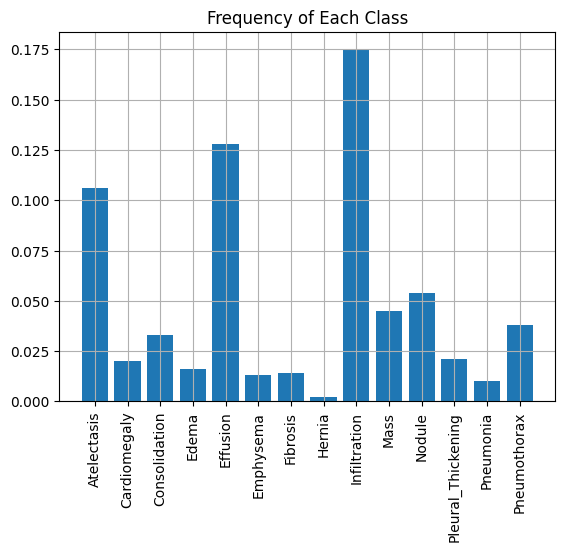

In [47]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_df_labels, axis=0))
plt.title("Frequency of Each Class")
plt.grid()
plt.show()